In [49]:
%load_ext autoreload
%autoreload
%matplotlib widget
import importlib
from SOAEpeaks import load_df
import phaseco as pc
from phaseco import *
from tqdm import tqdm
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import scipy as sp
from scipy.signal.windows import gaussian
from scipy.optimize import curve_fit
import os
importlib.reload(pc)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'phaseco' from 'c:\\Users\\Owner\\OneDrive\\Documents\\GitHub\\phase-coherence\\phaseco\\__init__.py'>

In [2]:


# Get different species
df = load_df(laptop=True, dfs_to_load=["Curated Data"])
wf_list = []
for species in ['Anolis', 'Owl', 'Human']:
    df_species = df[df['species'] == species]
    for i in range (3):
        row = df_species.iloc[i]
        wf_fn = row['filepath'].split('\\')[-1]
        wf_list.append((row['wf'], row['sr'], wf_fn, species))
del df

Loading Curated Data
Combining into one Dataframe!


In [69]:
wf_idx = 6 # Started with 0, 2 (Lizard) - 4, 5 (Owl) - 6, 7 (Human)

wf, fs, wf_fn, species = wf_list[wf_idx]

# Set parameters (same for human and lizard)
tau = 2**12 / 44100 # Everyone uses the same tau
tauS = int(tau*fs)
# Raise warning if tauS is not a power of two AND the samplerate is indeed 44100
if np.log2(tauS) != int(np.log2(tauS)):
    if fs == 44100:
        raise ValueError("tauS is not a power of 2, but the samplerate is 44100!")
    else:
        print(f"WARNING: tauS is not a power of 2, but the samplerate is {fs} (not 44100), so we'll assume you're just ensuring tau aligns with other waveforms!")

rho = 1

if species == 'Human':
    # Human parameters
    min_xi = 0.001
    max_xi = 1
    delta_xi = 0.001
    if wf_fn == 'human_TH14RearwaveformSOAE.mat':
        max_xi = 2.5
    max_khz = 6
elif species in ['Lizard', 'Anolis']:
    # Lizard parameters
    min_xi = 0.001
    max_xi = 0.1
    delta_xi = 0.0005
    max_khz = 6
elif species == 'Owl':
    # Owl parameters
    min_xi = 0.001
    max_xi = 0.1
    delta_xi = 0.0005
    max_khz = 12
    
print(f"Loaded {wf_fn}")

if 0:
    operation = 'generate+save'
else:
    operation = 'open'

Loaded human_TH14RearwaveformSOAE.mat


In [ ]:
# Calculate coherences (if needed)
if operation == 'generate+save':
    num_xis = int((max_xi - min_xi) / delta_xi) + 1
    xis = np.linspace(min_xi, max_xi, num_xis)

    max_xiS = max(xis) * fs
    f = rfftfreq(tauS, 1/fs)
    # Make sure we have a consistent number of segments to take vector strenght over since this will change with xi
    N_segs = int((len(wf) - tauS) / max_xiS)    

    coherences = np.zeros((len(f), len(xis)))
    print(f"Calculating coherence for wf {wf_fn} with {len(xis)} xi values")
    for i, xi in enumerate(tqdm(xis)):
        coherences[:, i] = get_coherence(wf=wf, fs=fs, tauS=tauS, xi=xi, ref_type="next_seg", N_segs=N_segs, rho=rho)[1]

In [71]:
# Save/open coherences
suptitle=rf"[{wf_fn}]   [$\rho$={rho}]   [$\tau$={tau*1000:.2f}ms]" 
fn_id = rf"tau={tau*1000:.0f}, rho={rho}, {species}, {wf_fn.split('.')[0]}"
pkl_fn = f'C_xi Decay Coherences - {fn_id}'
pkl_folder = r'Pickles/'
fig_folder = r'Colossogram Figures/C_xi Decay Figures/'

if operation == 'generate+save':
    with open(pkl_folder + pkl_fn + '.pkl', 'wb') as file:
        pickle.dump((coherences, f, xis, tau, rho, wf_fn, species), file)
elif operation == 'open':
    with open(pkl_folder + pkl_fn + '.pkl', 'rb') as file:
        coherences, f, xis, tau, rho, wf_fn, species = pickle.load(file)

FileNotFoundError: [Errno 2] No such file or directory: 'Pickles/C_xi Decay Coherences - tau=93, rho=1, Human, human_TH14RearwaveformSOAE.pkl'

In [72]:
# Peak pick the target bins
if wf_fn == 'anole_AC6rearSOAEwfB1.mat': # 0
    peak_freqs = [1225, 2150, 4300]
    noise_freqs = [400, 12000]
elif wf_fn == 'anole_ACsb18learSOAEwfG4.mat': # 2
    peak_freqs = [990, 2000, 3670]
    noise_freqs = [400, 12000]
elif wf_fn == 'owl_Owl6L1.mat': # 4
    peak_freqs = [4867, 6384, 7235]
    noise_freqs = [400, 12000]
elif wf_fn == 'owl_TAG4learSOAEwf1.mat': # 5
    peak_freqs = [6280, 7820, 10487]
    noise_freqs = [400, 12000]
elif wf_fn == 'human_TH14RearwaveformSOAE.mat': # 6
    peak_freqs = [603, 2250, 4370]
    noise_freqs = [400, 12000]
elif wf_fn == 'human_TH21RearwaveformSOAE.mat': # 7
    peak_freqs = [2000, 2605, 4135]
    noise_freqs = [400, 12000]
else:
    raise(Exception("Haven't peak picked this waveform yet!"))
    

bin_idxs = []
bin_names = []

for peak_freq in peak_freqs:
    bin_idxs.append(np.argmin(np.abs(f - peak_freq)))
    bin_names.append(f"{peak_freq:.0f}Hz Peak")

for noise_freq in noise_freqs:
    bin_idxs.append(np.argmin(np.abs(f - noise_freq)))
    bin_names.append(f"{noise_freq:.0f}Hz Noise")
    
freq_list = peak_freqs + noise_freqs

In [73]:
# Plot colossogram
if 0:
    plt.close('all')
    plt.figure(figsize=(15, 5))
    plot_colossogram(coherences, f, xis, tau, max_khz=max_khz, cmap='magma')
    plt.title(f"{species} Colossogram", fontsize=18)
    plt.suptitle(suptitle, fontsize=10)
    plt.savefig(f'{fig_folder}C_xi Colossogram - {fn_id}.png', dpi=300)
    plt.show()

In [74]:
# Plot a slice of the colossogram with target bins marked
if 0:
    target_xi = 0.02
    xi_idx = np.argmin(np.abs(xis - target_xi))
    coherence_slice = coherences[:, xi_idx]
    psd = get_welch(wf=wf, fs=fs, tauS=tauS)[1]
    # psd_xi = get_welch(wf=wf, fs=fs, tauS=tauS, xi=target_xi)[1]


    plt.close('all')
    plt.figure(figsize=(12, 5))
    plt.suptitle(suptitle)
    plt.subplot(2, 1, 1)
    plt.title(rf"{species} Colossogram Slice at $\xi={xis[xi_idx]:.3f}$")
    plt.plot(f / 1000, coherence_slice)
    for freq, plot_idx in zip(freq_list, bin_idxs):
        plt.scatter(f[plot_idx] / 1000, coherence_slice[plot_idx], c='r')
    plt.xlabel("Frequency (kHz)")
    plt.ylabel(r'$C_{\xi}$')
    plt.xlim(0, max_khz)
    plt.subplot(2, 1, 2)
    plt.title(rf"{species} PSD")
    plt.plot(f / 1000, np.log10(psd), label='PSD')
    #plt.plot(f / 1000, np.log10(psd_xi), label=r'PSD ($\xi$)')
    for freq, plot_idx in zip(freq_list, bin_idxs):
        plt.scatter(f[plot_idx] / 1000, np.log10(psd[plot_idx]), c='r')
        #plt.scatter(f[idx] / 1000, np.log10(psd_xi[idx]), c='r')
    plt.xlabel("Frequency (kHz)")
    plt.ylabel("PSD [dB]")  
    plt.legend()
    plt.xlim(0, max_khz)
    plt.tight_layout()
    plt.savefig(f'{fig_folder}C_xi Decay Target Bins - {fn_id}.png', dpi=300)
    plt.show()

In [75]:
def get_is_signal(coherences, f, xis, f_target_idx, f_noise=12000, sample_hw=5, z_alpha=0.05, crop=False):
    f_noise_idx = (np.abs(f - f_noise)).argmin()  # find frequency bin index closest to our 12kHz cutoff
    # Get mean and std dev of coherence (over frequency axis, axis=0) for each xi value (using only "noise" frequencies above our cutoff)
    noise_means = np.mean(coherences[f_noise_idx:, :], axis=0) 
    noise_stds = np.std(coherences[f_noise_idx:, :], axis=0, ddof=1) # ddof=1 since we're using sample mean (not true mean) in sample std estimate
    # Now for each xi value, run a z-test to see if it's noise or not
    is_signal = np.full(len(xis), True, dtype=bool)
    for xi_idx in range(len(xis)):
        # Skip xi values that are too close to the edges to get a full sample
        if xi_idx < sample_hw:
            is_signal[xi_idx] = True
            continue
        elif xi_idx >= len(xis) - sample_hw:
            is_signal[xi_idx] = False
        coherence_sample = coherences[f_target_idx, xi_idx - sample_hw: xi_idx + sample_hw]
        # Calculate z test statistic
        sample_mean = np.mean(coherence_sample)
        z = (sample_mean - noise_means[xi_idx]) / (noise_stds[xi_idx]/np.sqrt(len(coherence_sample)))
        # Calculate p-value for a one-tailed test (sf = survival function = 1 - cdf)
        p = sp.stats.norm.sf(z)
        is_signal[xi_idx] = p < z_alpha
    target_coherences=coherences[f_target_idx, :]
    if crop:
        is_signal = is_signal[sample_hw:-sample_hw]
        xis = xis[sample_hw:-sample_hw]
        target_coherences = target_coherences[f_target_idx, sample_hw:-sample_hw]
    
    decayed_idx = -1
    # Find decayed point
    for i in range(len(is_signal)):
        if not crop and i < sample_hw: # These are automatically set to signal anyway but what the heck
            continue
        if not is_signal[i]:
            decayed_idx = i
            break
    if decayed_idx == -1:
        print(f"Signal at {f[f_target_idx]:.0f}Hz never decays!")
    xi_decayed = xis[decayed_idx]
    
    return is_signal, xis, target_coherences, xi_decayed, decayed_idx
def exp_decay(x, tc, amp):
    return amp * np.exp(-x/tc)

def gauss_decay(x, tc, amp):
    return amp * np.exp(-x**2/tc)

def sigmoid_amp(x, tc, amp):
    return amp / (1 + np.exp((x)/tc))

def sigmoid_loc(x, tc, loc):
    return 1 / (1 + np.exp((x-loc)/tc))

def sigmoid_amp_loc(x, tc, amp, loc):
    return amp / (1 + np.exp((x-loc)/tc))

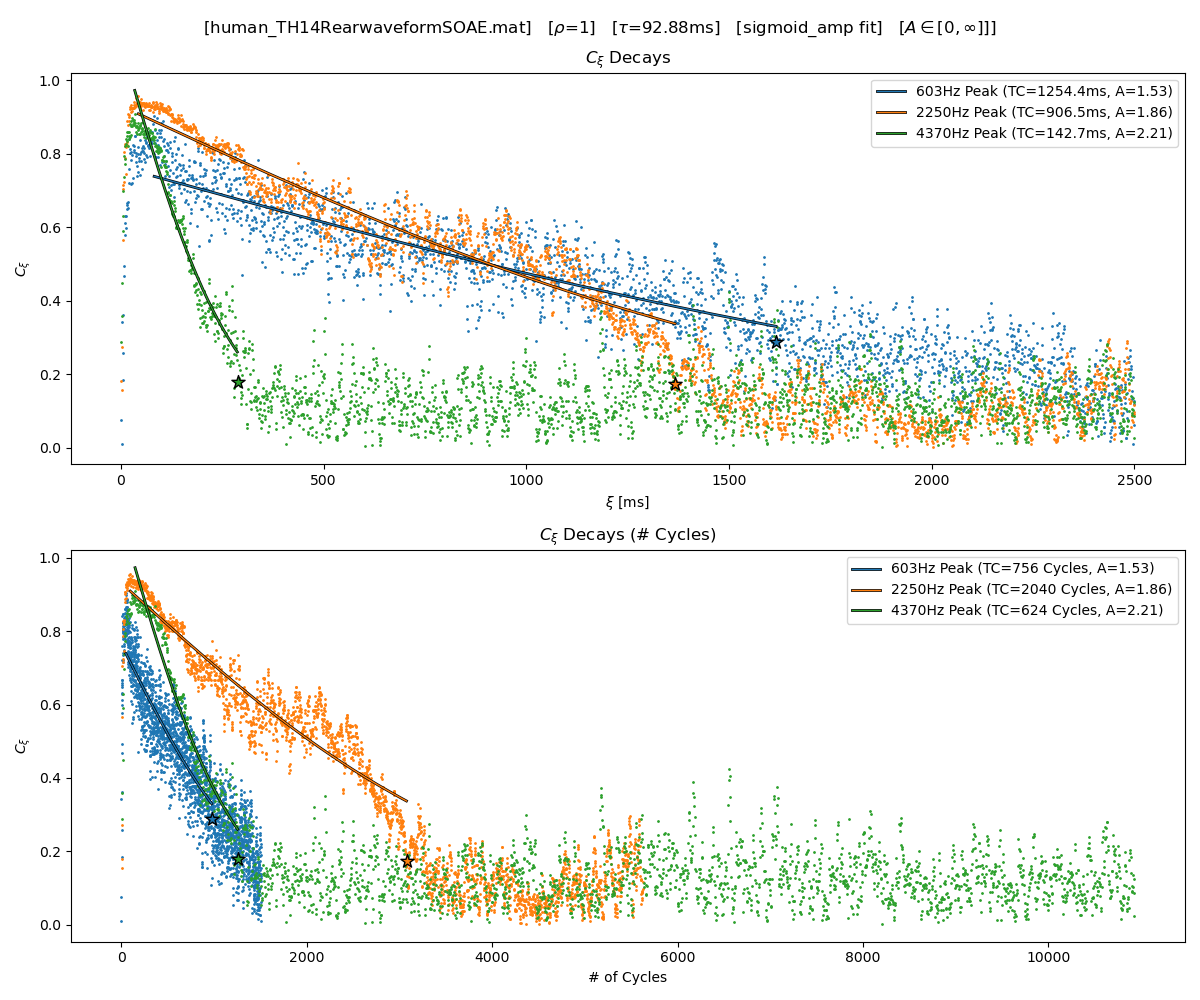

In [ ]:
# Compare xi scale vs # cycles scale

# Z-Test Parameters
sample_hw = 10
z_alpha = 0.05 # Minimum p-value for z-test; we assume noise unless p < z_alpha (so higher z_alpha means more signal bins)

# Fitting Parameters
fit = True
min_fit_xi_idx = 1
trim_step = 10
sigma_weighting_power = 1 # > 0 means less weight on lower coherence bins 
fit_func_type = 'sigmoid_amp'
A_max = np.inf # 1 or np.inf
get_fit_sigma = lambda y, sigma_weighting_power: y/y # 1 / (y**sigma_weighting_power+ 1e-9)




# Plotting parameters
s_signal=1
s_noise=1
s_decayed = 100
plot_noise = False
marker_signal='o'
marker_noise='o'
marker_decayed='*'
lw_fit = 1.5
alpha_fit = 1
pe_stroke_fit = [pe.Stroke(linewidth=2, foreground='black', alpha=1), pe.Normal()]  
edgecolor_signal=None
edgecolor_noise=None
edgecolor_decayed='black'
crop=False
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


# Take care of effects of parameters

# Take care of A restriction
suptitle=rf"[{wf_fn}]   [$\rho$={rho}]   [$\tau$={tau*1000:.2f}ms]   [{fit_func_type} fit]" 
if fit_func_type!='sigmoid_loc':
    if A_max == 1:
        suptitle = suptitle + r"   [$A \in [0, 1]$]]"
        A_max_str = 'A in [0, 1]'
    elif A_max == np.inf:
        suptitle = suptitle + r"   [$A \in [0, \infty]$]]"
        A_max_str = 'A in [0, infty]'
    else:
        raise(Exception("Invalid A_max"))
else:
    A_max_str = ''

# Set default p0 / param3_label
p0 = [1, 1]
param3_label = None

# Deal with different functions
match fit_func_type:
    case 'exp':
        bounds = ([0, 0], [np.inf, A_max]) # [tc, amp]
        fit_func = exp_decay
        param2_label = 'A'
    case 'gauss':
        bounds = ([0, 0], [np.inf, A_max]) # [tc, amp]
        fit_func = gauss_decay
        param2 = 'A'
    case 'sigmoid_amp':
        bounds = ([0, 0], [np.inf, A_max]) # [tc, amp]
        fit_func = sigmoid_amp
        param2_label = 'A'
    case 'sigmoid_loc':
        bounds = ([0, -np.inf], [np.inf, np.inf]) # [tc, loc]
        fit_func = sigmoid_loc
        param2_label = 'loc'
    case 'sigmoid_amp_loc': 
        bounds = ([0, 0, -np.inf], [np.inf, A_max, np.inf]) # [tc, amp, loc]
        fit_func = sigmoid_amp_loc
        param2_label = 'A'
        param3_label = 'loc'
        p0 = [1, 1, 1]
    

# FIT AND PLOT

plt.close('all')
plt.figure(figsize=(12, 10))
plt.suptitle(suptitle)

for f_target_idx, bin_name, color in zip(bin_idxs, bin_names, colors):  
    # (Possibly) skip noise bins
    noise_bin = 'Noise' in bin_name
    if not plot_noise and noise_bin: 
        continue   
    
    # Calculate signal vs noise and point of decay
    is_signal, xis_plot, target_coherences_plot, xi_decayed, decayed_idx = get_is_signal(coherences, f, xis, f_target_idx, f_noise=12000, sample_hw=sample_hw, z_alpha=z_alpha, crop=crop)
    is_noise = ~is_signal
    
            
        
    # Curve Fit
    
    if fit and not noise_bin:
        print(f"Fitting {fit_func_type} to {bin_name} with {A_max_str} on {wf_fn} with rho={rho}")
        fit_start_idx = np.argmax(target_coherences_plot[min_fit_xi_idx:]) + min_fit_xi_idx
        x_to_fit = xis_plot[fit_start_idx:decayed_idx]
        y_to_fit = target_coherences_plot[fit_start_idx:decayed_idx]
        sigma = get_fit_sigma(y_to_fit, sigma_weighting_power) 
        attempts = 0
        popt = None
        while len(x_to_fit) > trim_step and popt is None:
            try:
                popt, pcov = curve_fit(fit_func, x_to_fit, y_to_fit, p0=p0, sigma=sigma, bounds=bounds)
                break  # Fit succeeded!
            except (RuntimeError, ValueError) as e:
                attempts += 1
                x_to_fit = x_to_fit[:-trim_step]
                y_to_fit = y_to_fit[:-trim_step]
                sigma = sigma[:-trim_step]
                print(f"Fit failed (attempt {attempts}): — trimmed to {len(x_to_fit)} points")
        if popt is None:
            print(f"Curve fit failed after all attemps ({bin_name} from {wf_fn} with {fit_func_type} fit and {A_max_str})")
            continue
        else:
            print("Fitting successful!")
        y_fitted = fit_func(x_to_fit, *popt)
        tc = popt[0]
        param2 = popt[1]
        # Handle case where there's three parameters
        if len(popt) > 2:
            param3 = popt[2] 
            param3_label_str = f', {param3_label}={param3:.2f}'
        else: 
            param3_label_str = ""
            
    
    # Plot this peak
    f_target = f[f_target_idx]
    tc_labels = [f"{tc*1000:.1f}ms", f"{tc*f_target:.0f} Cycles"]
    for xdim, subplot_idx, tc_label in zip(['Xi', '# Cycles'], [1, 2], tc_labels):
        plt.subplot(2, 1, subplot_idx)
        fit_label = bin_name + rf" (TC={tc_label}, {param2_label}={param2:.2f}" + param3_label_str + ")"
        alpha=0.3 if noise_bin else 1 
        scatter_label = None if fit else bin_name
        x = xis_plot  * f_target if xdim == '# Cycles' else xis_plot * 1000
        x_fitted = x_to_fit * f_target if xdim == '# Cycles' else x_to_fit * 1000
        
        
        plt.scatter(x[is_signal], target_coherences_plot[is_signal], s=s_signal, edgecolors=edgecolor_signal, marker=marker_signal, color=color, alpha=alpha, zorder=1)
        plt.scatter(x[is_noise], target_coherences_plot[is_noise], s=s_noise, color=color, label=scatter_label, edgecolors=edgecolor_noise, alpha=alpha, zorder=1)
        if not noise_bin: 
            # Mark decayed point
            plt.scatter(x[decayed_idx], target_coherences_plot[decayed_idx], s=s_decayed, marker=marker_decayed, color=color, edgecolors=edgecolor_decayed, zorder=3)
            if fit:
                plt.plot(x_fitted, y_fitted, color=color, label=fit_label, lw=lw_fit, path_effects=pe_stroke_fit, alpha=alpha_fit, zorder=2)
        

# Finish up plot
plt.subplot(2, 1, 1)
plt.xlabel(r'$\xi$ [ms]')
plt.ylabel(r'$C_{\xi}$')           
plt.title(r"$C_{\xi}$ Decays")
plt.legend()

plt.subplot(2, 1, 2)
plt.title(r"$C_{\xi}$ Decays (# Cycles)")
plt.xlabel(r'# of Cycles')
plt.ylabel(r'$C_{\xi}$')           
plt.legend()

# Prevent us from getting hella noise for the 12kHz one
max_target_f_idx = np.max(bin_idxs[0:-2]) # Get the largest peak frequency
max_num_cycles = xis[-1] * f[max_target_f_idx] # Get corresponding max number of cycles
# plt.xlim(0, max_num_cycles) 

# Book it!
plt.tight_layout()
fig_subfolder = rf'/Fitted C_xi Decays (rho={rho})/{fit_func_type} fits'
if A_max_str != '':
    fig_subfolder+=f'/{A_max_str}'
    fn_A_max_str = f', {A_max_str}'

os.makedirs(fig_folder+fig_subfolder, exist_ok=True)    
plt.savefig(f'{fig_folder}{fig_subfolder}/{fn_id} - C_xi Decays Fitted with {fit_func_type}{fn_A_max_str}.png', dpi=300)
plt.show()
    

In [21]:
# Plot decays on various scales

if 0:
    # Parameters
    sample_hw = 10
    z_alpha = 0.05 # Minimum p-value for z-test; we assume noise unless p < z_alpha (so higher z_alpha means more signal bins)

    # Plotting parameters
    s_signal=1
    s_noise=1
    s_decayed = 100
    plot_noise = False
    marker_signal='o'
    marker_noise='o'
    marker_decayed='*'
    edgecolor_signal=None
    edgecolor_noise=None
    edgecolor_decayed='black'
    crop=False
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    for xdim in ['Xi', '# Cycles']:
        fig_subfolder = fr'/Decays on Various Scales ({xdim})/'
        suptitle = rf"$C_{{\xi}}$ Decays ({xdim})"
        plt.close('all')
        plt.figure(figsize=(12, 10))
        plt.suptitle(suptitle)
        for scale, plot_idx in zip(['normal', 'log', 'gauss'], [1, 2, 3]):
            plt.subplot(3, 1, plot_idx)
            for f_target_idx, bin_name, color in zip(bin_idxs, bin_names, colors):
                if not plot_noise and 'Noise' in bin_name:
                    continue   
                alpha=0.3 if 'Noise' in bin_name else 1    
                
                is_signal, xis_plot, target_coherences_plot, xi_decayed, decayed_idx = get_is_signal(coherences, f, xis, f_target_idx, f_noise=12000, sample_hw=sample_hw, z_alpha=z_alpha, crop=crop)
                is_noise = ~is_signal
                
                title = r"$C_{\xi}$ Decays"
                
                # Rescale
                match scale:
                    case 'normal':
                        plt.ylabel(r'$C_{\xi}$')
                    case 'log':
                        target_coherences_plot = np.log(target_coherences_plot)
                        plt.ylabel(r'$\ln(C_{\xi})$')
                        title+= " (Log Scale)"
                    case 'gauss':
                        target_coherences_plot = -np.sqrt(-np.log(target_coherences_plot))
                        plt.ylabel(r'$-\sqrt{-\ln(C_{\xi})}$')
                        title+= " (Inverse Gaussian Scale)"          
                plt.title(title)
                
                alpha=1
                if 'Noise' in bin_name:
                    alpha=0.3
                if xdim == '# Cycles':
                    x = xis_plot * f[f_target_idx] # Nondimensionalize
                    xlabel = '# of Cycles'
                else:
                    x = xis_plot*1000
                    xlabel = r'$\xi$ (ms)'
                
                plt.scatter(xis_plot[is_signal]*1000, target_coherences_plot[is_signal], s=s_signal, edgecolors=edgecolor_signal, marker=marker_signal, color=color, alpha=alpha)
                plt.scatter(xis_plot[is_noise]*1000, target_coherences_plot[is_noise], s=s_noise, color=color, label=bin_name, edgecolors=edgecolor_noise, alpha=alpha)
                
                if 'Noise' not in bin_name:
                    plt.scatter(xi_decayed*1000, target_coherences_plot[decayed_idx], s=s_decayed, marker=marker_decayed, color=color, edgecolors=edgecolor_decayed)

        plt.xlabel(xlabel)
        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.savefig(f'{fig_folder}{fig_subfolder}C_xi Decay Various Scales - {xdim} - {fn_id}.png', dpi=300)
        plt.show()

In [ ]:
# # DIPS
# def xi_decayed(coherences, f, xis, f_target_idx, f_noise=12000, N_persistence=10, dip_prop=0.7):
#     """
#     Parameters
#     ----------
#     coherences : 2D array
#         Coherence values for each frequency bin and xi value
#     f : 1D array
#         Frequency bins
#     xis : 1D array
#         xi values
#     f_target_idx : int
#         Index of target frequency
#     f_noise : float, optional
#         Noise cutoff frequency, by default 12kHz

#     Returns
#     -------
#     xi_decayed : double
#         xi value at which the peak decay is reached
#     """
#     f_noise_idx = (np.abs(f - f_noise)).argmin()  # find frequency bin index closest to our 12kHz cutoff
#     coherences_noise = coherences[f_noise_idx:, :]
#     noise_means = np.mean(coherences_noise, axis=0)
#     noise_stds = np.std(coherences_noise, axis=0) # get standard deviation of coherence (over frequency axis, axis=0) for each xi value (using only "noise" frequencies above our cutoff)
#     noise_floor = noise_means + noise_stds
#     dips = coherences[f_target_idx, :] < noise_floor
#     for xi_idx in range(len(xis)):
#         if dips[xi_idx]:
#             next_num_dips = sum(dips[xi_idx:xi_idx + N_persistence])
#             if next_num_dips >= dip_prop * N_persistence:
#                 xi_decayed = xis[xi_idx]
#                 xi_decayed_idx = xi_idx
#                 return xi_decayed_idx, xi_decayed
#     else:
#         xi_decayed = xis[-1]
#         xi_decayed_idx = len(xis)
#         return xi_decayed_idx, xi_decayed


# # Plot decays on various scales

# s_coherences=1
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# for xdim in ['Xi', '# Cycles']:
#     plt.figure(figsize=(12, 10))
#     plt.suptitle(suptitle)
#     for scale, plot_idx in zip(['normal', 'log', 'gauss'], [1, 2, 3]):
#         plt.subplot(3, 1, plot_idx)
#         for f_target_idx, bin_name, color in zip(bin_idxs, bin_names, colors):
#             target_coherences = coherences[f_target_idx, :]
#             xi_decayed_idx, xi_decayed = xi_decayed(coherences, f, xis, f_target_idx)
#             title = r"$C_{\xi}$ Decays"
#             if scale == 'normal':
#                 plt.ylabel(r'$C_{\xi}$')
#             if scale == 'gauss':
#                 target_coherences = -np.sqrt(-np.log(target_coherences))
#                 plt.ylabel(r'$-\sqrt{-\ln(C_{\xi})}$')
#                 title+= " (Inverse Gaussian Scale)"
#             elif scale == 'log':
#                 target_coherences = np.log(target_coherences)
#                 plt.ylabel(r'$\ln(C_{\xi})$')
#                 plt.title("Log Scale")
#                 title+= " (Log Scale)"            
#             plt.title(title)
#             z_alpha=1
#             if 'Noise' in bin_name:
#                 z_alpha=0.3
#             if xdim == '# Cycles':
#                 x = xis * f[f_target_idx] # Nondimensionalize
#                 xlabel = '# of Cycles'
#             else:
#                 x = xis*1000
#                 xlabel = r'$\xi$ (ms)'
#             plt.scatter(x, target_coherences, label=bin_name, alpha=z_alpha, s=s_coherences, color=color)
#             plt.scatter(x[xi_decayed_idx], target_coherences[xi_decayed_idx], marker='x', label=f'{bin_name} Decay Xi', s=10, color=color)
#         plt.xlabel(xlabel)
#         plt.legend(loc='upper right')
#     plt.tight_layout()
#     plt.savefig(f'{fig_folder}C_xi Decay Scales - {xdim} - {fn_id}.png', dpi=300)
#     plt.show()
    
    
# # Compare xi scale vs # cycles scale

# s_coherences=1
# s_decay=100
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# plt.figure(figsize=(12, 10))
# plt.suptitle(suptitle)

# # Xi scale
# plt.subplot(2, 1, 1)
# title = r"$C_{\xi}$ Decays"
# for f_target_idx, bin_name, color in zip(bin_idxs, bin_names, colors):
#     target_coherences = coherences[f_target_idx, :]
#     xi_decayed_idx, xi_decayed = xi_decayed(coherences, f, xis, f_target_idx)    
#     plt.ylabel(r'$C_{\xi}$')           
#     plt.title(title)
#     z_alpha=1
#     if 'Noise' in bin_name:
#         z_alpha=0.3
#     plt.scatter(xis*1000, target_coherences, label=bin_name, alpha=z_alpha, s=s_coherences, color=color)
#     plt.scatter(xis[xi_decayed_idx]*1000, target_coherences[xi_decayed_idx], marker='*', s=s_decay, color=color, edgecolors='black', zorder=10)
# plt.xlabel(r'$\xi$ [ms]')
# plt.legend()

# # Num Cycles scale
# plt.subplot(2, 1, 2)
# title = r"$C_{\xi}$ Decays (# Cycles)"
# for f_target_idx, bin_name, color in zip(bin_idxs, bin_names, colors):
#     target_coherences = coherences[f_target_idx, :]
#     xi_decayed_idx, xi_decayed = xi_decayed(coherences, f, xis, f_target_idx)
#     nums_cycles = xis * f[f_target_idx] # Nondimensionalize
#     plt.ylabel(r'$C_{\xi}$')           
#     plt.title(title)
#     z_alpha=1
#     if 'Noise' in bin_name:
#         z_alpha=0.3
#     plt.scatter(nums_cycles, target_coherences, label=bin_name, alpha=z_alpha, s=s_coherences, color=color)
#     plt.scatter(nums_cycles[xi_decayed_idx], target_coherences[xi_decayed_idx], marker='*', s=s_decay, color=color, edgecolors='black', zorder=10)
# plt.xlabel(r'# of Cycles')
# # Prevent us from getting hella noise for the 12kHz one
# max_target_f_idx = np.max(bin_idxs[0:-2]) # Get the largest peak frequency
# max_num_cycles = xis[-1] * f[max_target_f_idx] # Get corresponding max number of cycles
# plt.xlim(0, max_num_cycles) 
# plt.legend()

# # Book it!
# plt.tight_layout()
# plt.savefig(f'{fig_folder}C_xi Decays Xi vs # Cycles - {fn_id}.png', dpi=300)
# plt.show()
    
